# Set-up

## Package management

In [55]:
# --- Standard library ---
import sys
import pickle
from enum import Enum
import random

# --- Scientific computing ---
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# --- Network science ---
from cdlib import algorithms
import networkx as nx

# --- Data handling and visualization ---
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

import seaborn as sns

# --- Miscelleaneous ---
from tqdm.auto import tqdm

# --- Project source code ---
sys.path.append("../../")
sys.path.append("../../src/")

# Data
from src.data.preprocessing import duplex_network  # handle overlap, inconsistent node sets
from src.data.benchmarks import lfr_multiplex  # benchmark samplers

# Sampling
from src.sampling.random import partial_information  # PFI observation

# Embedding
from src.embed.LE import LE

# Classifiers
from src.classifiers.features import *  # degree feature calculations, label wrapper
from src.classifiers.logreg import *  # wrappers for scikit-learn logistic regression model functions

# Utils
from src.utils.parameters import set_parameters_LE

## Global config

In [56]:
# * Pathing aliases
_ROOT = "../../"
_DATA = _ROOT + "data/input/"
_DFS = _ROOT + "results/dataframes/"
_FIGS = _ROOT + "results/plots/"

In [57]:
# * Plotting parameters
custom_plot_settings = {
    # Figure config
    "figure.figsize": (8,6),
    "figure.frameon": True,
    "figure.autolayout": True,
    "axes.titlesize": 16,
    # Axes config
    "xtick.minor.size": 2,
    # Save-to-disk config
    "savefig.facecolor": "white",
    "savefig.transparent": False
}
mpl.rcParams.update(custom_plot_settings)

# * Plotting aliases
colors_ = ["black", "red", "blue", "green"]
markers_ = ["o", "s", "+", "^"]
viridis_ = mpl.colormaps['viridis']

## Data set-up

In [58]:
# --- Describing attributes ---
_ATTR_DICT = {
    "N": "number of nodes (in shared node set)",
    "T1": "degree exponent of power-law degree distribution (from sampled distribution, finite sampling effects may yield different exponent if re-fit)",
    "MU": "mixing parameter for LFR model. Smaller MU implies (and is implied by) stronger modular structure.",
    "KMIN": "minimum degree (in either layer)",
    "KMAX": "maximum degree (in either layer)",
    "KAVG": "average degree (in both layers)",
    "T2": "community size power-law distribution exponent",
    "PROB": "relabeling probability. Controls correlation, with 0->1 = correlated->uncorrelated",
    "SIGN": "degree sequence sorting. Couples with PROB to produce anti/directly correlated degree sequences. -1 => anticorrelated, 1 => correlated"
}

In [59]:
# --- Data/Experiment Configurations ---
class NetworkParams(Enum):
    # Shared params
    N = 1000
    PROB = 1.0
    T1 = 2.1
    KMAX = np.sqrt(1000)
    # Configuration model params
    KMIN = 3
    SIGN = 1
    # LFR params
    KAVG = 5.0
    T2 = 1.0
    MU = 0.1
    MIN_COMMUNITY = 1 # ignored

class ExperimentParams(Enum):
    THETAS = np.linspace(0.05, 0.95, 11, endpoint=True)

LOGREG = {
    "fit_intercept": True,  # include intercept accounting for class imbalance
    "solver": "newton-cholesky",  # uses Cholesky-decomposition to approximate Hessian for Newton-esque method
    "penalty": None  # do not include coefficient regularization
}

## Function set-up

In [60]:
def get_network(
        N=int(NetworkParams.N.value),  # number of nodes
        T1=NetworkParams.T1.value,  # degree distribution exponent
        T2=NetworkParams.T2.value,  # community size distribution exponent
        MU=NetworkParams.MU.value,  # community mixing parameter
        KAVG=NetworkParams.KAVG.value,  # average degree
        KMAX=NetworkParams.KMAX.value,  # maximum degree
        MIN_COMMUNITY=NetworkParams.MIN_COMMUNITY.value,  # minimum community size (ignored)
        PROB=NetworkParams.PROB.value,  # degree sequence correlation,
        ROOT="../../"):
    duplex, _, _, _ = lfr_multiplex(N, T1, T2, MU, KAVG, KMAX, MIN_COMMUNITY, PROB, ROOT)
    duplex = duplex_network(duplex, 1, 2, verbose=True)

    return duplex

In [61]:
def get_remnants(theta, G, H):
    remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)
    record = {
        "remnants": (remnant_G, remnant_H),
        "observed_edges": train_edges,
        "unobserved_edges": test_edges
    }

    return record

In [62]:
def embed_remnants(
        remnants_record,
        params, hyperparams,
        normalize=True,
        per_component=False,
        nodelist=None):
    G, H = remnants_record["remnants"]
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]

    embeddings_G = LE(G, params, hyperparams, per_component=per_component, nodelist=nodelist)
    embeddings_H = LE(H, params, hyperparams, per_component=per_component, nodelist=nodelist)

    distances_G_train, distances_H_train = get_distances((embeddings_G, embeddings_H), E_train)
    distances_G_test, distances_H_test = get_distances((embeddings_G, embeddings_H), E_test)

    # * >>> Match FR notebook >>>
    # distances_G_train = [x**2 for x in distances_G_train]
    # distances_H_train = [x**2 for x in distances_H_train]
    # distances_G_test = [x**2 for x in distances_G_test]
    # distances_H_test = [x**2 for x in distances_H_test]
    # * <<< Match FR notebook <<<

    feature_distances_train = get_configuration_distances_feature(distances_G_train, distances_H_train, zde_penalty=0.1)
    feature_distances_test = get_configuration_distances_feature(distances_G_test, distances_H_test, zde_penalty=0.1)

    if normalize:
        normalizer = max(np.abs(feature_distances_train))
        feature_distances_train = list(map(lambda x: x / normalizer, feature_distances_train))

        normalizer = max(np.abs(feature_distances_test))
        feature_distances_test = list(map(lambda x: x / normalizer, feature_distances_test))

    return feature_distances_train, feature_distances_test

In [63]:
def get_degree_features(remnants_record):
    G, H = remnants_record["remnants"]
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]
    # Partially compute degree likelihood feature
    src_degrees_train, tgt_degrees_train = get_degrees((G, H), E_train)
    src_degrees_test, tgt_degrees_test = get_degrees((G, H), E_test)

    # Complete degree likelihood feature calculations
    feature_degrees_train = get_configuration_probabilities_feature(src_degrees_train, tgt_degrees_train)
    feature_degrees_test = get_configuration_probabilities_feature(src_degrees_test, tgt_degrees_test)

    return feature_degrees_train, feature_degrees_test

In [64]:
def train_test_model(remnants_record, distances, degrees):
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]

    # Retrieve data labels
    Y_train, Y_test = get_labels(E_train, E_test)

    # Unpack training features
    dist_train, dist_test = distances
    degs_train, degs_test = degrees
    X_train, X_test = format_feature_matrix(
        {"emb", "imb", "deg"},
        len(E_train), len(E_test),
        dist_train, dist_test,
        degs_train, degs_test
    )

    # Train model
    model = train_fit_logreg(X_train, Y_train, LOGREG)

    # Evaluate model
    accuracy = get_model_accuracy(model, X_test, Y_test)
    auroc = get_model_auroc(model, X_test, Y_test)
    aupr = get_model_aupr(model, X_test, Y_test)

    # Pack output
    output = {
        "model": model,
        "intercept": model.intercept_[0],
        "coefs": model.coef_[0],
        "accuracy": accuracy,
        "auroc": auroc,
        "aupr": aupr,
    }

    return output

In [65]:
def analysis(G, H):
    df = dict()

    params, hyperparams, _ = set_parameters_LE(maxiter=10_000)
    hyperparams = hyperparams["embedding"]
    nodelist = sorted(G.nodes())

    for theta in tqdm(ExperimentParams.THETAS.value, desc="Sweeping theta..."):
        remnants_record = get_remnants(theta, G, H)
        degrees = get_degree_features(remnants_record)

        df_ = dict()
        for dimensions in np.linspace(10, 100, num=11, dtype=int):
            params["k"] = dimensions
            distances = embed_remnants(remnants_record, params, hyperparams, nodelist=nodelist)

            df_[dimensions] = train_test_model(remnants_record, distances, degrees)
        df[theta] = df_

    return df

# Experiment

In [66]:
results = dict()  # t2 -> results
for T2 in np.linspace(1, 4, num=4, endpoint=True):
    print(f"\n\n--- T2 = {T2} ---\n")
    G, H = get_network(T2=T2)
    results[T2] = analysis(G, H)



--- T2 = 1.0 ---

Number of common edges removed: 15
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


Sweeping theta...: 100%|██████████| 11/11 [00:40<00:00,  3.71s/it]




--- T2 = 2.0 ---

Number of common edges removed: 10
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


Sweeping theta...: 100%|██████████| 11/11 [01:09<00:00,  6.28s/it]




--- T2 = 3.0 ---

Number of common edges removed: 8
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


Sweeping theta...: 100%|██████████| 11/11 [02:26<00:00, 13.29s/it]




--- T2 = 4.0 ---

Number of common edges removed: 6
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000


Sweeping theta...: 100%|██████████| 11/11 [01:13<00:00,  6.68s/it]


# Analysis

In [67]:
records = []
for T2, _a in results.items():
    for theta, _b in _a.items():
        for dim, perfs in _b.items():
            record = {
                "T2": T2,
                "theta": theta,
                "dim": dim
            }

            del perfs["model"]
            record.update(perfs)

            records.append(record)

df = pd.DataFrame.from_records(records)
df.to_csv(f"dataframe_EMB_ex36v2.0.csv")

<Figure size 800x600 with 0 Axes>

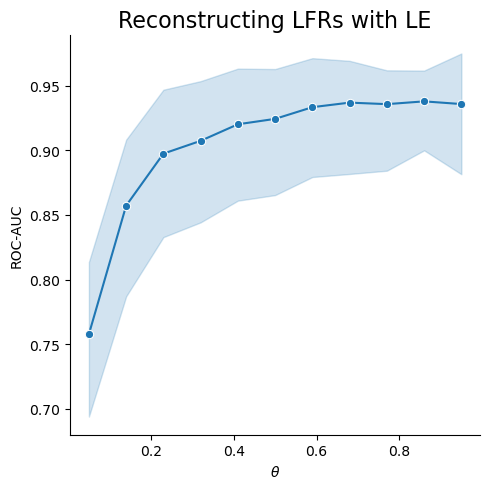

In [74]:
# Instantiate figure, subset relevant data
fig = plt.figure()
dim_ = 100
df_ = df.query("T2 in [1.0, 2.0, 3.0, 4.0] & dim == @dim_")  # in [10,28,46,64,82,100]

# Plotting data
sns.relplot(
    data=df_, kind="line",
    x="theta", y="auroc",
    # hue="T2", palette="viridis",
    marker="o"
)

# Axes configuration
plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")


# Figure-level attributes
plt.title("Reconstructing LFRs with LE")
# plt.text(0.5, 0.75, f"Dimension = {dim_}")


# Save plot
plt.tight_layout()
plt.savefig(f"{_FIGS}/line_auroc-pfi_LE-LFR.png")

<Figure size 800x600 with 0 Axes>

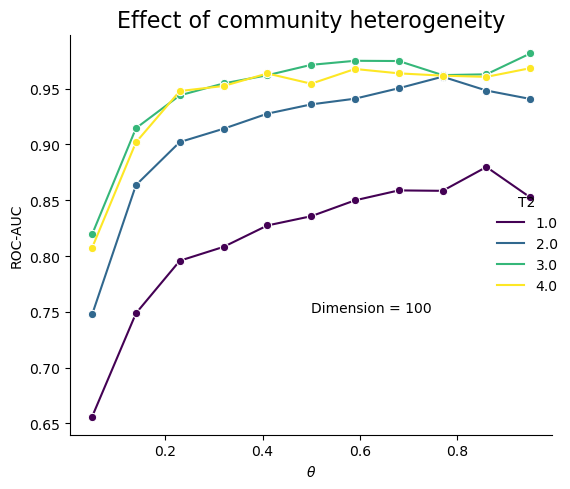

In [75]:
# Instantiate figure, subset relevant data
fig = plt.figure()
dim_ = 100
df_ = df.query("T2 in [1.0, 2.0, 3.0, 4.0] & dim == @dim_")  # in [10,28,46,64,82,100]

# Plotting data
sns.relplot(
    data=df_, kind="line",
    x="theta", y="auroc",
    hue="T2", palette="viridis",
    marker="o"
)

# Axes configuration
plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")


# Figure-level attributes
plt.title("Effect of community heterogeneity")
plt.text(0.5, 0.75, f"Dimension = {dim_}")


# Save plot
plt.tight_layout()
plt.savefig(f"{_FIGS}/line_auroc-pfi_hue-T2_dim-{dim_}_.png")

<Figure size 800x600 with 0 Axes>

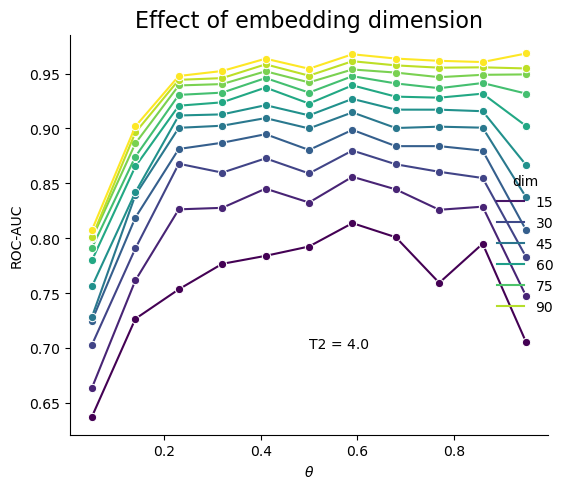

In [76]:
# Instantiate figure, subset relevant data
fig = plt.figure()
T2_ = 4.0
df_ = df.query("T2 == @T2_")  # in [10,28,46,64,82,100]

# Plotting data
sns.relplot(
    data=df_, kind="line",
    x="theta", y="auroc",
    hue="dim", palette="viridis",
    marker="o"
)

# Axes configuration
plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")


# Figure-level attributes
plt.title("Effect of embedding dimension")
plt.text(0.5, 0.7, f"T2 = {T2_}")


# Save plot
plt.tight_layout()
plt.savefig(f"{_FIGS}/line_auroc-pfi_hue-dim_T2-{T2_}_.png")